Trong ví dụ trước, đầu vào có cả chiều dài và chiều rộng cùng bằng $3$, cửa sổ hạt nhân tích chập có cả chiều dài và chiều rộng cùng bằng $2$, nên ta thu được biểu diễn đầu ra có kích thước $2×2$. Nói chung, giả sử kích thước của đầu vào là $n_h×n_w$ và kích thước của cửa sổ hạt nhân tích chập là $k_h×k_w$, kích thước của đầu ra sẽ là:
$$
(n_h-k_h+1) \times (n_w-k_w+1).
$$
Do đó, kích thước của đầu ra tầng tích chập được xác định bởi kích thước đầu vào và kích thước cửa sổ hạt nhân tích chập.

Trong vài trường hợp, ta sẽ kết hợp thêm các kỹ thuật khác cũng có ảnh hưởng tới kích thước của đầu ra, như thêm phần đệm và phép tích chập sải bước. Lưu ý rằng vì các hạt nhân thường có chiều rộng và chiều cao lớn hơn  $1$ nên sau khi áp dụng nhiều phép tích chập liên tiếp, đầu ra thường có kích thước nhỏ hơn đáng kể so với đầu vào. Nếu ta bắt đầu với một ảnh có  $240×240$ điểm ảnh và áp dụng  $10$ tầng tích chập có kích thước $5×5$ thì kích thước ảnh này sẽ giảm xuống $200×200$ điểm ảnh, $30%$ của ảnh sẽ bị cắt bỏ và mọi thông tin có ích trên viền của ảnh gốc sẽ bị xóa sạch. Đệm là công cụ phổ biến nhất để xử lý vấn đề này.

Trong những trường hợp khác, ta có thể muốn giảm đáng kể kích thước ảnh, ví dụ như khi độ phân giải của đầu vào quá cao. Phép tích chập sải bước (Strided convolution) là một kỹ thuật phổ biến có thể giúp ích trong trường hợp này.

In [1]:
import torch
from torch import nn

# 7.3.1. Đệm (Padding)

Như mô tả ở trên, một vấn đề rắc rối khi áp dụng các tầng tích chập là việc chúng ta có thể mất một số điểm ảnh trên biên của ảnh. Vì chúng ta thường sử dụng các hạt nhân nhỏ, với một phép tích chập ta có thể chỉ mất một ít điểm ảnh, tuy nhiên sự mất mát này có thể tích lũy dần khi ta thực hiện qua nhiều tầng tích chập liên tiếp. Một giải pháp đơn giản cho vấn đề này là chèn thêm các điểm ảnh xung quanh đường biên trên bức ảnh đầu vào, nhờ đó làm tăng kích thước sử dụng của bức ảnh. Thông thường, chúng ta thiết lập các giá trị của các điểm ảnh thêm vào là $0$. Trong hình dưới, ta đệm một đầu vào  $3×3$, làm tăng kích thước lên thành $5×5$. Đầu ra tương ứng sẽ tăng lên thành một ma trận  $4×4$.
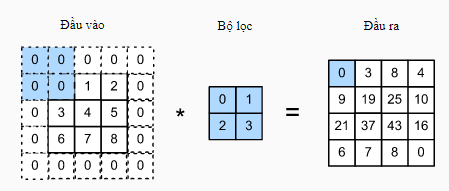

 

Tương quan chéo hai chiều khi thực hiện đệm. Phần tô đậm là các phần tử của mảng đầu vào và hạt nhân được sử dụng để tính phần tử đầu ra thứ nhất:
$$
0\times0+0\times1+0\times2+0\times3=0
$$

Nhìn chung nếu chúng ta chèn thêm tổng cộng  $p_h$ hàng đệm (phân nửa ở phía trên và phân nửa ở phía dưới) và $p_w$ cột đệm (phân nửa bên trái và phân nửa bên phải), kích thước đầu ra sẽ là:
$$
(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1).
$$

Trong nhiều trường hợp, ta sẽ muốn thiết lập $p_h=k_h-1$
 và $p_h=k_h-1$ để đầu vào và đầu ra có cùng chiều dài và chiều rộng. Điều này sẽ giúp việc dự đoán kích thước đầu ra của mỗi tầng dễ dàng hơn khi ta xây dựng mạng. Giả sử $k_h$ ở đây chẵn, ta sẽ chèn $p_h/2$
hàng ở cả phía trên và phía dưới. Nếu $k_h$ lẻ, ta có thể chèn $⌈p_h/2⌉$ hàng ở phía trên của đầu vào và $⌊p_h/2⌋$ hàng cho phía dưới. Chúng ta cũng thực hiện chèn cả hai bên của chiều ngang tương tự như vậy.

Các mạng nơ-ron tích chập thường sử dụng các hạt nhân tích chập với chiều dài và chiều rộng là số lẻ, như  $1, 3, 5$ hay $7$. Việc chọn hạt nhân có kích thước lẻ giúp chúng ta bảo toàn được các chiều không gian khi thêm cùng số hàng đệm cho cạnh trên và dưới, và thêm cùng số cột đệm cho cạnh trái và phải.

Hơn nữa, việc sử dụng bộ lọc kích thước lẻ cùng đệm để giữ nguyên số chiều mang lại một lợi ích khác. Với mảng hai chiều X bất kì, khi kích thước bộ lọc lẻ và số hàng và số cột đệm bằng nhau, thu được đầu ra có cùng chiều dài và chiều rộng với đầu vào, ta sẽ biết chắc chắn rằng mỗi phần tử đầu ra $Y[i, j]$ được tính bằng phép tương quan chéo giữa đầu vào và hạt nhân tích chập có tâm nằm tại $X[i, j]$.

Trong ví dụ dưới, chúng ta tạo một tầng tích chập hai chiều với chiều dài và chiều rộng $3 $ và đệm $1$ điểm ảnh vào viền các cạnh. Với đầu vào có chiều dài và chiều rộng là $8$, ta thấy rằng chiều dài và chiều rộng đầu ra cũng là 8.

In [10]:
def comp_conv2d(conv2d, X):
  X = X.reshape((1,1) + X.shape) # Khai báo thêm chiều batch và chiều kênh
  Y = conv2d(X)
  return Y.reshape(Y.shape[2:])


In [11]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

# 7.3.2. Sải bước (Stride)

Khi thực hiện phép tương quan chéo, ta bắt đầu với cửa sổ tích chập tại góc trên bên trái của mảng đầu vào, rồi di chuyển sang phải và xuống dưới qua tất cả các vị trí. Trong các ví dụ trước, ta mặc định di chuyển qua một điểm ảnh mỗi lần. Tuy nhiên, có những lúc để tăng hiệu suất tính toán hoặc vì muốn giảm kích thước của ảnh, ta di chuyển cửa sổ tích chập nhiều hơn một điểm ảnh mỗi lần, bỏ qua các vị trí ở giữa.

Ta gọi số hàng và cột di chuyển qua mỗi lần là sải bước (stride). Cho đến giờ, chúng ta sử dụng sải bước $1$ cho cả chiều dài và chiều rộng. Đôi lúc, chúng ta có thể muốn sử dụng sải bước lớn hơn. Hình dưới biểu diễn phép tương quan chéo hai chiều với sải bước $3$ theo chiều dọc và $2$ theo chiều ngang. Có thể thấy rằng khi tính giá trị phần tử thứ hai của cột đầu tiên, cửa sổ tích chập di chuyển xuống ba hàng. Cửa sổ này di chuyển sang phải hai cột khi tính giá trị phần tử thứ hai của hàng đầu tiên. Khi cửa sổ di chuyển sang phải ba cột ở đầu vào, giá trị đầu ra không tồn tại vì các phần tử đầu vào không lấp đầy cửa sổ (trừ khi ta thêm một cột đệm).

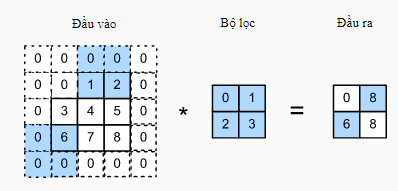

Phép tương quan chéo với sải bước 3 theo chiều dài và và 2 theo chiều rộng. Phần tô đậm là các phần tử đầu ra, các phần tử đầu vào và bộ lọc được sử dụng để tính các đầu ra này:
$$
0\times0+6\times1+0\times2+0\times3=6
$$

Nhìn chung, khi sải bước theo chiều cao là $s_h$ và sải bước theo chiều rộng là $s_w$, kích thước đầu ra là:
$$
\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.
$$

Nếu đặt $p_h=k_h-1$ và $p_w=k_w-1$, kích thước đầu ra sẽ được thu gọn thành $\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$. Hơn nữa, nếu chiều cao và chiều rộng của đầu vào chia hết cho sải bước theo chiều cao và chiều rộng tương ứng thì kích thước đầu ra sẽ là $(n_h/s_h) \times (n_w/s_w)$.

Dưới đây, chúng ta đặt sải bước cho cả chiều cao và chiều rộng là $2$, do đó chiều cao và chiều rộng của đầu ra bằng một nửa chiều cao và chiều rộng của đầu vào.

In [15]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

Hãy xem một ví dụ phức tạp hơn một chút.

In [19]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

Để đơn giản hóa vấn đề, khi phần đệm theo chiều cao và chiều rộng của đầu vào lần lượt là $p_h$ và $p_w$, chúng ta sẽ kí hiệu phần đệm là $(p_h,p_w)$. Ở trường hợp đặc biệt khi  $p_h=p_w=p$, ta kí hiệu phần đệm là $p$. Khi sải bước trên chiều cao và chiều rộng lần lượt là $s_h$ và $s_w$, chúng ta kí hiệu sải bước là $(s_h,s_w)$. Ở trường hợp đặc biệt khi $s_h=s_w=s$, ta kí hiệu sải bước là $s$. Mặc định, phần đệm là $0$ và sải bước là $1$. Trên thực tế, ít khi chúng ta sử dụng các giá trị khác nhau cho sải bước hoặc phần đệm, tức ta thường đặt $p_h=p_w$ và $s_h=s_w$.